## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os

Text(0.5,1,'Undistorted Image')

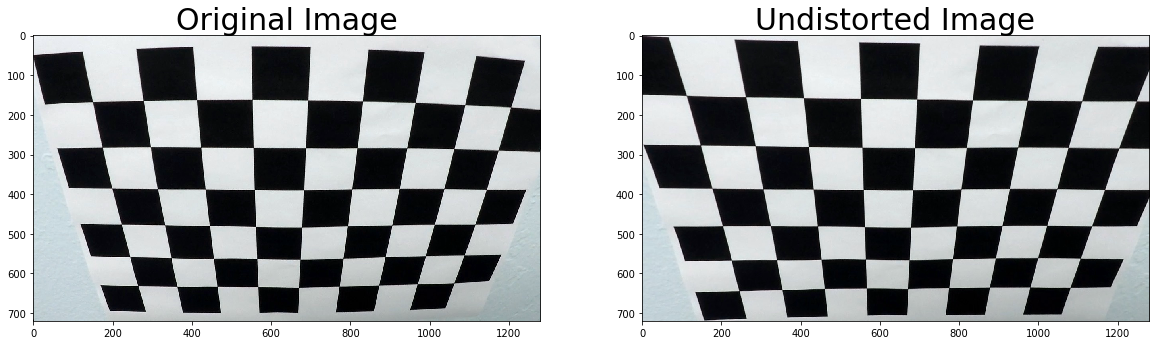

In [2]:
# Camera calibration
# chessboard size
nx = 9
ny = 6
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        #cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        #write_name = 'camera_cal_output/'+'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration2.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration give object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [ ]:
# Save the camera calibration result for later use
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )

In [2]:
# Read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load( open( "wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

## Second, define functions that get undistort image, binary image, perspective transformed image, and warped image. Find lane line pixels, fit line curves, calculate geometry, and draw back to the image.

In [3]:
# Undistort image
def undistort_image(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# Get binary image
def create_binary(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    #combined thresholds
    combined = np.zeros_like(s_binary)
    combined[(sxbinary == 1) | (s_binary == 1)] = 1
    #return combined
    return combined

# Perspective transform to an undistorted image
#define src
src = np.float32([[585, 460],
                  [203, 720],
                  [1127, 720],
                  [695, 460]])
#define dst
dst = np.float32([[320, 0],
                  [320, 720],
                  [960, 720],
                  [960, 0]])
Minv = cv2.getPerspectiveTransform(dst, src)
def warper(img, src, dst):
    # Compute and apply perpective transform
    # The img should be an undistorted image
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image
    return warped

# Use slide windows to find lane pixels and fitting results for the first frame
def find_lane_pixels_fit_poly(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  
        win_xleft_high = leftx_current + margin  
        win_xright_low = rightx_current - margin  
        win_xright_high = rightx_current + margin  
        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        ### If  found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(x=lefty, y=leftx, deg=2)
    right_fit = np.polyfit(x=righty, y=rightx, deg=2)
    # Return
    return left_fit, right_fit

# Use previous fitting results for finding lane pixels
def search_around_poly_refit(binary_warped):
    # Declare global variables
    global left_fit_pool, left_fit_avg, right_fit_pool, right_fit_avg
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 100
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### consider the window areas for the similarly named variables ###
    ### in the previous, but change the windows to new search area ###
    left_lane_inds = ((nonzerox >= left_fit_avg[0]*nonzeroy**2+left_fit_avg[1]*nonzeroy+left_fit_avg[2]-margin) & 
    (nonzerox < left_fit_avg[0]*nonzeroy**2+left_fit_avg[1]*nonzeroy+left_fit_avg[2]+margin))
    right_lane_inds = ((nonzerox >= right_fit_avg[0]*nonzeroy**2+right_fit_avg[1]*nonzeroy+right_fit_avg[2]-margin) & 
    (nonzerox < right_fit_avg[0]*nonzeroy**2+right_fit_avg[1]*nonzeroy+right_fit_avg[2]+margin))
    # extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit new polynomials
    left_fit = np.polyfit(x=lefty, y=leftx, deg=2)
    right_fit = np.polyfit(x=righty, y=rightx, deg=2)
    # Check any large deviation and update fitting results
    left_conditions = np.absolute(left_fit-left_fit_avg)/left_fit_avg < 10
    #left_conditions = abs(np.log10(left_fit/left_fit_avg)) < 1.3
    if False in left_conditions:
        left_fit = np.copy(left_fit_avg)
    left_fit_pool = update_fit(left_fit_pool, left_fit, holder=7)
    left_fit_avg = np.mean(left_fit_pool, axis=0)
    right_conditions = np.absolute(right_fit-right_fit_avg)/right_fit_avg < 10
    if False in right_conditions:
        right_fit = np.copy(right_fit_avg)
    right_fit_pool = update_fit(right_fit_pool, right_fit, holder=7)
    right_fit_avg = np.mean(right_fit_pool, axis=0)
    #Generate x and y values for plotting
    img_shape = binary_warped.shape
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ###  Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    #return
    return left_fitx, right_fitx, ploty, left_fit, right_fit, leftx, lefty, rightx, righty
    
def color_lane_region(undist, binary_warped, left_fitx, right_fitx, ploty, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (binary_warped.shape[1], binary_warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

def geometry(img, ploty, left_fitx, right_fitx, leftx, lefty, rightx, righty, left_fit, right_fit):
    # Radius
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    ##### Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = (1+(2*left_fit[0]*y_eval+left_fit[1])**2)**(3.0/2)/abs(2*left_fit[0])  
    right_curverad = (1+(2*right_fit[0]*y_eval+right_fit[1])**2)**(3.0/2)/abs(2*right_fit[0])  
    # Meters
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    y_eval_cr = y_eval*ym_per_pix
    left_curverad_cr = (1+(2*left_fit_cr[0]*y_eval_cr+left_fit_cr[1])**2)**(3.0/2)/abs(2*left_fit_cr[0])
    right_curverad_cr = (1+(2*right_fit_cr[0]*y_eval_cr+right_fit_cr[1])**2)**(3.0/2)/abs(2*right_fit_cr[0])
    # Offset from center
    veh_middle = int(img.shape[1]/2)
    lane_middle = int((left_fitx[-1]+right_fitx[-1])/2)
    offset_dir = 'left' if veh_middle<=lane_middle else 'right'
    offset_meter = abs(veh_middle-lane_middle)*xm_per_pix
    # Return
    return left_curverad, right_curverad, left_curverad_cr, right_curverad_cr, offset_dir, offset_meter

# Update fitting results
def update_fit(fit_pool, fit_new, holder=7):
    fit_pool = np.vstack([fit_pool, fit_new])
    if fit_pool.shape[0]>holder:
        fit_pool = np.delete(fit_pool, (0), axis=0)
    return fit_pool

## Third, check whether functions work properly

## 3.1 Check the distortion correction has been correctly applied to each image

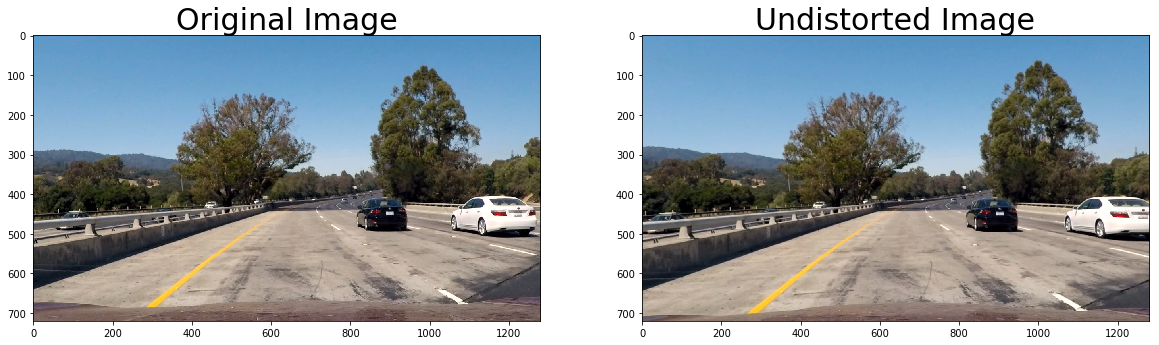

In [10]:
# Test distortion correction correct
test_img = mpimg.imread('test_images/test1.jpg')
undist_test_img = undistort_image(test_img, mtx, dist)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist_test_img)
ax2.set_title('Undistorted Image', fontsize=30)

# Apply distortion correction to all test images and save results to output_images
for image_name in os.listdir("test_images/"):
    test_img = mpimg.imread("test_images/"+image_name)
    undist_test_img = undistort_image(test_img, mtx, dist)
    mpimg.imsave("output_images/"+"undist_"+image_name, undist_test_img)

## 3.2 Check a binary image has been created using color transforms, gradients or other methods

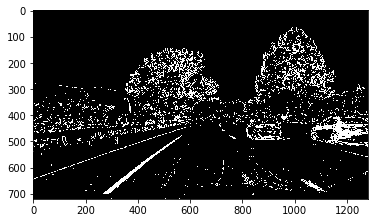

In [4]:
# Test binary images created using gradients and color transformation
test_img = mpimg.imread('test_images/test1.jpg')
undist_test_img = undistort_image(test_img, mtx, dist)
binary_test_image = create_binary(undist_test_img)

# Visualize binary image
plt.imshow(binary_test_image, cmap='gray')

## 3.3 Check a perspective transform has been applied to rectify the image

Text(0.5,1,'Warped result with dest. points drawn')

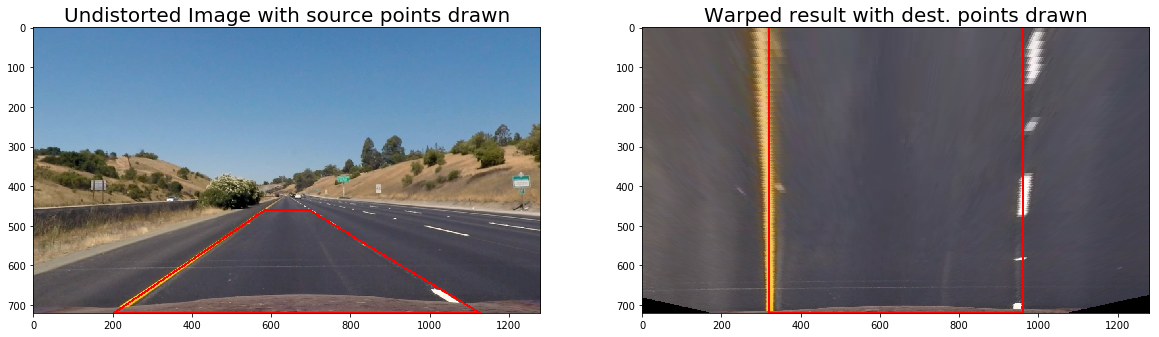

In [28]:
# Test perspective transform
test_img = mpimg.imread('test_images/straight_lines1.jpg')
undist_test_img = undistort_image(test_img, mtx, dist)
warped_test_image = warper(undist_test_img, src, dst)
cv2.polylines(undist_test_img, [src.astype(int).reshape((-1,1,2))], True, (255,0,0), thickness=4)
cv2.polylines(warped_test_image, [dst.astype(int).reshape((-1,1,2))], True, (255,0,0), thickness=4)

# Visualize binary image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undist_test_img)
ax1.set_title('Undistorted Image with source points drawn', fontsize=20)
ax2.imshow(warped_test_image)
ax2.set_title('Warped result with dest. points drawn', fontsize=20)

## Fourth, define pipeline that processes video

In [5]:
# Define pipeline to process images
def process_image(image):
    #undistort image
    undist_image = undistort_image(image, mtx, dist)
    #get binary image
    binary_image = create_binary(undist_image)
    #perspective transform image
    binary_warped = warper(binary_image, src, dst)
    #fit
    left_fitx, right_fitx, ploty, left_fit, right_fit, leftx, lefty, rightx, righty = search_around_poly_refit(binary_warped)
    #calculate geometry
    left_curverad, right_curverad, left_curverad_cr, right_curverad_cr, offset_dir, offset_meter = geometry(binary_warped, ploty, left_fitx, right_fitx, leftx, lefty, rightx, righty, left_fit, right_fit)
    #draw lane regions
    result = color_lane_region(undist_image, binary_warped, left_fitx, right_fitx, ploty, Minv)
    #draw geometry on result image
    cv2.putText(result, "Radius of Curvature = {0}(m)".format(int(right_curverad_cr)), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(result, "Vehicle is {0}(m) {1} of center".format(round(offset_meter,2), offset_dir), (50, 120), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2, cv2.LINE_AA)
    return result

## Fifth, process video and show results

In [6]:
# Find the first frame of video, use slide windows to find left_fit and right_fit
first_frame = VideoFileClip("project_video.mp4").get_frame(t=0)
#undistort image
undist_frame = undistort_image(first_frame, mtx, dist)
#get binary image
binary_frame = create_binary(undist_frame)
#perspective transform image
binary_warped_frame = warper(binary_frame, src, dst)
#use slide windows
left_fit, right_fit = find_lane_pixels_fit_poly(binary_warped_frame)
# Store fitting results and average fitting results
left_fit_pool = np.array([left_fit])
right_fit_pool = np.array([right_fit])
left_fit_avg = np.mean(left_fit_pool, axis=0)
right_fit_avg = np.mean(right_fit_pool, axis=0)

In [7]:
white_output = 'project_video_output.mp4'
clip = VideoFileClip("project_video.mp4")
white_clip = clip.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [04:39<00:00,  4.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 2min 19s, sys: 19.7 s, total: 2min 38s
Wall time: 4min 42s


In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))